# Chain animation
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.7' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

## Load

In [2]:
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2

save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_ao0.5_evlpt_lo1_pckaiser_obfield/'
save_path = save_dir + 'sMCLMC_nc4_ns64'

# Load truth
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
model = FieldLevelModel(**default_config)
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
start = 2
end = 3

# Load chains
thinning = 1
transforms = [
            lambda x: x[['*~diverging']],
            partial(Chains.thin, thinning=thinning), 
            model.reparam_chains, 
            partial(model.powtranscoh_chains, mesh0=mesh0),
            # partial(Chains.choice, n=10, names=['init','init_']),
            ]
chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
print(chains.shape)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_ao0.5_evlpt_lo1_pckaiser_obfield/


2025-02-21 09:03:29.509938: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading: sMCLMC_nc4_ns64, from run 2 to run 3 (included)
{'Omega_m': (4, 128), 'b1': (4, 128), 'b2': (4, 128), 'bn2': (4, 128), 'bs2': (4, 128), 'init_mesh': (4, 128, 64, 64, 64), 'kptc': ((4, 128, 15), (4, 128, 15), (4, 128, 15), (4, 128, 15)), 'mse_per_dim': (4, 128), 'n_evals': (4, 128), 'sigma8': (4, 128)}


## Plot

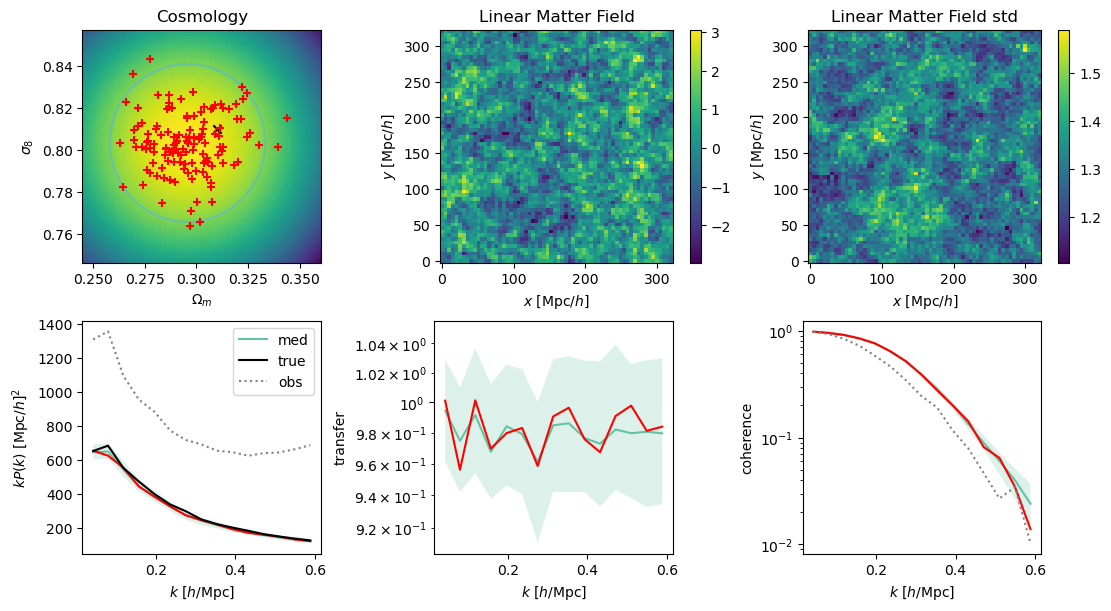

In [7]:
from montecosmo.plot import plot_powtranscoh, plot_coh, plot_pow, plot_mesh, theme, mean_slice, plot_bivar
from montecosmo.utils import vlim
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
theme()

i_c = 0
i_plt = 10
sli = 0.1
log = False
prob = 0.95

plt.figure(figsize=(11, 6), layout='constrained')

plt.subplot(231)
xys = chains[i_c]['cosmo']
xy0 = Chains(truth, model.groups)['cosmo']
n_plt = len(xys[0])
lims = tree.map(partial(vlim, level=0.99, scale=1.5), xys)

kde = KernelDensity(kernel='gaussian', bandwidth='scott', atol=1e-5, rtol=1e-5)
xs = jnp.stack(xys).T
kde.fit(xs)
pdf = lambda x: jnp.exp(kde.score_samples(x))

# probs = np.array([0.68, 0.95, 0.997])
probs = np.array([0.95])
levels = jnp.quantile(pdf(xs), 1-probs[::-1])

plot_bivar(pdf, lims, n=100, type='mesh')
plot_bivar(pdf, lims, n=100, type='contour', colors=[SetDark2(0)], levels=levels, zorder=1)

xy = tree.map(lambda x: x[:i_plt], xys)
labels = [chains.labels[k] for k in chains.groups['cosmo']]

plt.scatter(*xy0, marker='x', color='k')
scat = plt.scatter(*xys, marker='+', color='r')
plt.xlabel(f'${labels[0]}$'), plt.ylabel(f'${labels[1]}$')
plt.xlim(lims[0]), plt.ylim(lims[1])
plt.title('Cosmology')


plt.subplot(232)
meshes = chains[i_c]['init']
mesh = meshes[i_plt]
quad1 = plot_mesh(mesh, model.box_shape, sli=sli)
plt.title('Linear Matter Field')
plt.colorbar()


plt.subplot(233)
# diff = mesh - mesh0
# quad2 = plot_mesh(diff, model.box_shape, sli=sli, cmap='PRGn')
stds = meshes.std(0)
quad2 = plot_mesh(stds, model.box_shape, sli=sli, cmap='viridis')
plt.title('Linear Matter Field std')
plt.colorbar()


axes = [plt.subplot(234), plt.subplot(235), plt.subplot(236)]
kptcs = chains[i_c]['kptc']
plot_powtranscoh(*jnp.median(jnp.stack(kptcs), 1), axes=axes, label='med')
plot_powtranscoh(*kptcs, fill=prob, axes=axes)

kptc = tree.map(lambda x: x[i_plt], kptcs)
lines = plot_powtranscoh(*kptc, log=log, color='r', axes=axes)
lines = [l[0] for l in lines]

plt.subplot(234)
plot_pow(*pow0, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(235)
plt.ylim(vlim(kptcs[2], scale=1.1, axis=(0,1)))

plt.subplot(236)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')
# plt.legend()



def update(i):
    xy = tree.map(lambda x: x[:i], xys)
    scat.set_offsets(jnp.stack(xy).T)

    mesh = meshes[i]
    mesh2d = mean_slice(mesh, sli)
    quad1.set_array(mesh2d)
    # diff2d = mean_slice(mesh - mesh0, sli)
    # quad2.set_array(diff2d)

    kptc = tree.map(lambda x: x[i], kptcs)
    ks, pow, trans, coh = kptc
    if not log:
        pow *= ks
    lines[0].set_data(ks, pow)
    lines[1].set_data(ks, trans)
    lines[2].set_data(ks, coh)

    return scat, quad1, quad2, *lines

anim = FuncAnimation(plt.gcf(), update, frames=n_plt, interval=100, repeat_delay=1000, blit=True)
display(anim)

In [8]:
anim.save("anim_chains.mp4")

## Canonical and MicroCanonical Hamiltonian trajectories